# **TR-2023/05 - Technical report: Self-Organizing Maps, Campinas, Brazil Groundwater Hydrochemical Dataset 2019**

|Technical Report ID  |2023/06|
|--|--|
| Title |Construction of Study Dataset|
| Authors | Diego Xavier Machado, Paula Dornhofer, Ana Elisa Abreu|
| Creation Date| 2023 - 06|


# Descrição Geral
Esse notebook tem como objetivo dividir a base de dados das coletas feitas pelo Instituto de Geociências da Unicamp (IG) com base na data em que as coletas foram feitas e aplicar o algoritmo *Self-Organizing Maps* (SOM) para obter grupos de poços relativamente semelhantes com base nos dados fornecidos, fornecendo também um mapeamento espacial de acordo com os rótulos obtidos após o agrupamento. Para isso, é necessário que a base de dados das coletas esteja tratada previamente.


In [1]:
#-----------------------------------------------------#
#              IMPORTAÇÃO DAS BIBIOTECAS              #
#-----------------------------------------------------#

!pip install pyproj
!pip install folium
!pip install sklearn-som
!pip install git+https://github.com/IanAguiar-ai/metrics.git
!pip install git+https://github.com/IanAguiar-ai/Self_Organizing_Maps.git

from pyproj import Proj
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from random import seed, random
from mutual_information import metrics as mtr
import som.som as som
from sklearn_som.som import SOM

  Cloning https://github.com/IanAguiar-ai/metrics.git to /tmp/pip-req-build-k1at0bvv
  Running command git clone --filter=blob:none --quiet https://github.com/IanAguiar-ai/metrics.git /tmp/pip-req-build-k1at0bvv
  Resolved https://github.com/IanAguiar-ai/metrics.git to commit 452d14433fbfdb08a40602b9f8512873c129157e
  Preparing metadata (setup.py) ... done
  Created wheel for metrics: filename=metrics-0.0.12-py3-none-any.whl size=17646 sha256=2b803597c13587da4d688b167d6cab3cba98bc30ef4356e70ee3d2e8b386e5d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-acz6k6vi/wheels/c7/48/53/4f50b27b511fdefedb30381ad08615e2dc2bae6ab5a0986841
Successfully built metrics
  Cloning https://github.com/IanAguiar-ai/Self_Organizing_Maps.git to /tmp/pip-req-build-en05p82x
  Running command git clone --filter=blob:none --quiet https://github.com/IanAguiar-ai/Self_Organizing_Maps.git /tmp/pip-req-build-en05p82x
  Resolved https://github.com/IanAguiar-ai/Self_Organizing_Maps.git to commit 955ef9600b2bf21d20d

# Importação dos arquivos
Para esse notebook, será necessário apenas o arquivo da base de dados das coletas, de forma já tratada, em arquivo `.csv`.

In [2]:
#-----------------------------------------------------#
#               IMPORTAÇÃO DOS ARQUIVOS               #
#-----------------------------------------------------#

from google.colab import drive
drive.mount('/content/drive')

# df = Base de dados
df = pd.read_csv('/content/drive/Shareddrives/datasci4water/IG/data/interim/df_final.csv')
df = df.reset_index(drop=True)

Mounted at /content/drive


# Separação da base de dados principal de acordo com a data:
Com a base de dados principal, será criado duas outras novas base de dados. Uma para cada período de coleta. Portanto a data é a variável responsável por essa divisão. Assim, formam-se, bases de dados para os seguintes períodos:


*   Abril de 2019
*   Outubro de 2019



In [3]:
#-----------------------------------------------------#
#         SEPARAÇÃO DA BASE DE DADOS POR DATA         #
#-----------------------------------------------------#

# Fazer a separação por data
df_abril = df.loc[df['date'] == '2019/04']
df_outubro = df.loc[df['date'] == '2019/10']

# Padronização dos valores
Como a base de dados possuem valores não numéricos referentes ao poço da amostra (coluna "*well*") e referente a data da coleta (coluna "*date*"), faremos a separação apenas dos valores numéricos para que o trabalho do algoritmo de aprendizado de máquina seja apenas sobre esses valores numéricos.

Ademais, como os valores possuem uma grande diferença entre ordens de grandeza, será feito a padronização desses valores, mantendo-os na mesma escala. Dessa  forma, pode-se evitar que variáveis com altas ordens de grandeza implique no cálculo de grandes distâncias entre os dados e influencie negativamente o funcionamento do algoritmo *K-Means*.

In [4]:
#-----------------------------------------------------#
#               PADRONIZAÇÃO DOS VALORES              #
#-----------------------------------------------------#

#  Separação dos valores numéricos
df_abril_values = df_abril.iloc[:, 2:df_abril.shape[1]]
df_outubro_values = df_outubro.iloc[:, 2:df_outubro.shape[1]]

# Padronização dos vallores propriamente dito
df_scaler = StandardScaler()
df_abril_values = df_scaler.fit_transform(df_abril_values)
df_outubro_values = df_scaler.fit_transform(df_outubro_values)

# Mudança no sistema de coordenadas
As coordenadas no Dataframe estão no sistema UTM. Para a utilização da biblioteca *folium* no qual serão impressos os rótulos do agrupamento, as coordenadas devem estar no sistema de graus decimais. Para isso, faz-se a conversão dos valores


In [5]:
#-----------------------------------------------------#
#                MUDANÇA DE COORDENADAS               #
#-----------------------------------------------------#

def utm_para_graus_decimais(easting, northing, lista_coordenadas):
    zona = 23
    hemisferio = 'S'
    proj = Proj(proj='utm', zone=zona, south=True, ellps='WGS84')
    longitude, latitude = proj(easting, northing, inverse=True)
    lista_coordenadas.append([latitude, longitude])


coordenadas_abril = []
coordenadas_outubro = []

for i in range(df_abril.shape[0]):
  utm_n = df_abril.iloc[i, 48]
  utm_e = df_abril.iloc[i, 47]
  utm_para_graus_decimais(utm_e, utm_n, coordenadas_abril)

for i in range(df_outubro.shape[0]):
  utm_n = df_outubro.iloc[i, 48]
  utm_e = df_outubro.iloc[i, 47]
  utm_para_graus_decimais(utm_e, utm_n, coordenadas_outubro)

# Métricas para o agrupamento do algoritmo SOM

## Métricas de Abril

In [6]:
SOM_abril = som.create_SOM(10, learning = 0.05)
som.n1_1.design_weights(df_abril_values)
som.n0_0.auto_organizing(epochs = 25, print_ = True)

Use object n1_1, it is your starting point for SOM...
To prepare the SOM for your data: n1_1.design_weights(YOUR_DATA) 
To start the SOM: n1_1.auto_organizing(epochs = 100)
 This function return the list of neurons
Adjust column 0
Adjust column 1
Adjust column 2
Adjust column 3
Adjust column 4
Adjust column 5
Adjust column 6
Adjust column 7
Adjust column 8
Adjust column 9
Adjust column 10
Adjust column 11
Adjust column 12
Adjust column 13
Adjust column 14
Adjust column 15
Adjust column 16
Adjust column 17
Adjust column 18
Adjust column 19
Adjust column 20
Adjust column 21
Adjust column 22
Adjust column 23
Adjust column 24
Adjust column 25
Adjust column 26
Adjust column 27
Adjust column 28
Adjust column 29
Adjust column 30
Adjust column 31
Adjust column 32
Adjust column 33
Adjust column 34
Adjust column 35
Adjust column 36
Adjust column 37
Adjust column 38
Adjust column 39
Adjust column 40
Adjust column 41
Adjust column 42
Adjust column 43
Adjust column 44
Adjust column 45
Adjust column

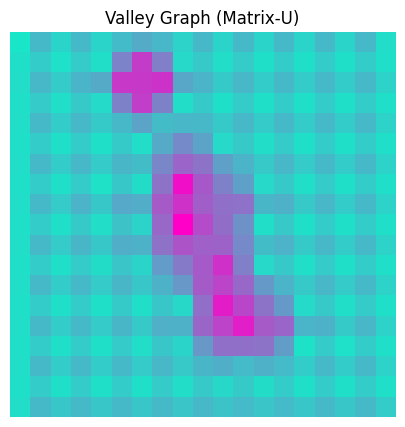

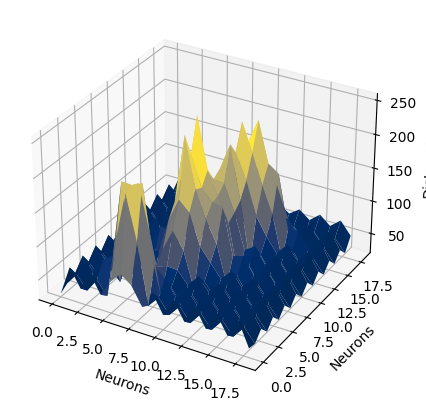

In [7]:
resp = som.n1_1.valley()

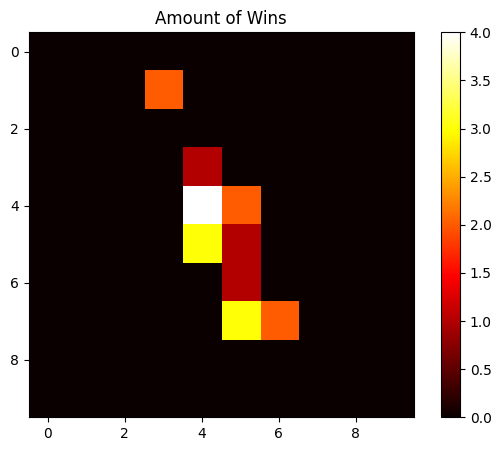

In [8]:
som.n1_1.amount_of_wins()

Max distance to join neurons: 0.257730561448872
Neuron 0: group 23
Neuron 1: group 24
Neuron 2: group 32
Neuron 3: group 8
Neuron 4: group 7
Neuron 5: group 3
Neuron 6: group 13
Neuron 7: group 11
Neuron 8: group 20
Neuron 9: group 18
Neuron 10: group 23
Neuron 11: group 24
Neuron 12: group 33
Neuron 13: group 53
Neuron 14: group 5
Neuron 15: group 1
Neuron 16: group 13
Neuron 17: group 11
Neuron 18: group 20
Neuron 19: group 18
Neuron 20: group 23
Neuron 21: group 25
Neuron 22: group 36
Neuron 23: group 38
Neuron 24: group 6
Neuron 25: group 2
Neuron 26: group 13
Neuron 27: group 11
Neuron 28: group 20
Neuron 29: group 18
Neuron 30: group 23
Neuron 31: group 25
Neuron 32: group 35
Neuron 33: group 39
Neuron 34: group 46
Neuron 35: group 4
Neuron 36: group 14
Neuron 37: group 11
Neuron 38: group 20
Neuron 39: group 18
Neuron 40: group 23
Neuron 41: group 25
Neuron 42: group 35
Neuron 43: group 40
Neuron 44: group 52
Neuron 45: group 47
Neuron 46: group 15
Neuron 47: group 10
Neuron 48:

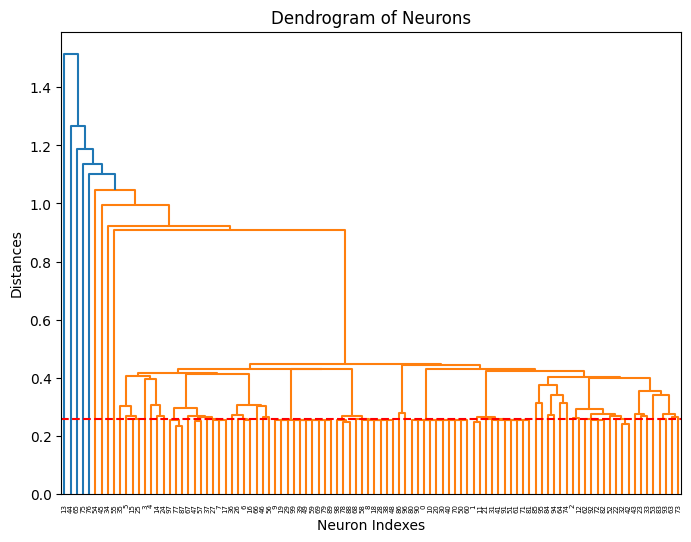

In [9]:
reps = som.n1_1.dendrogram()

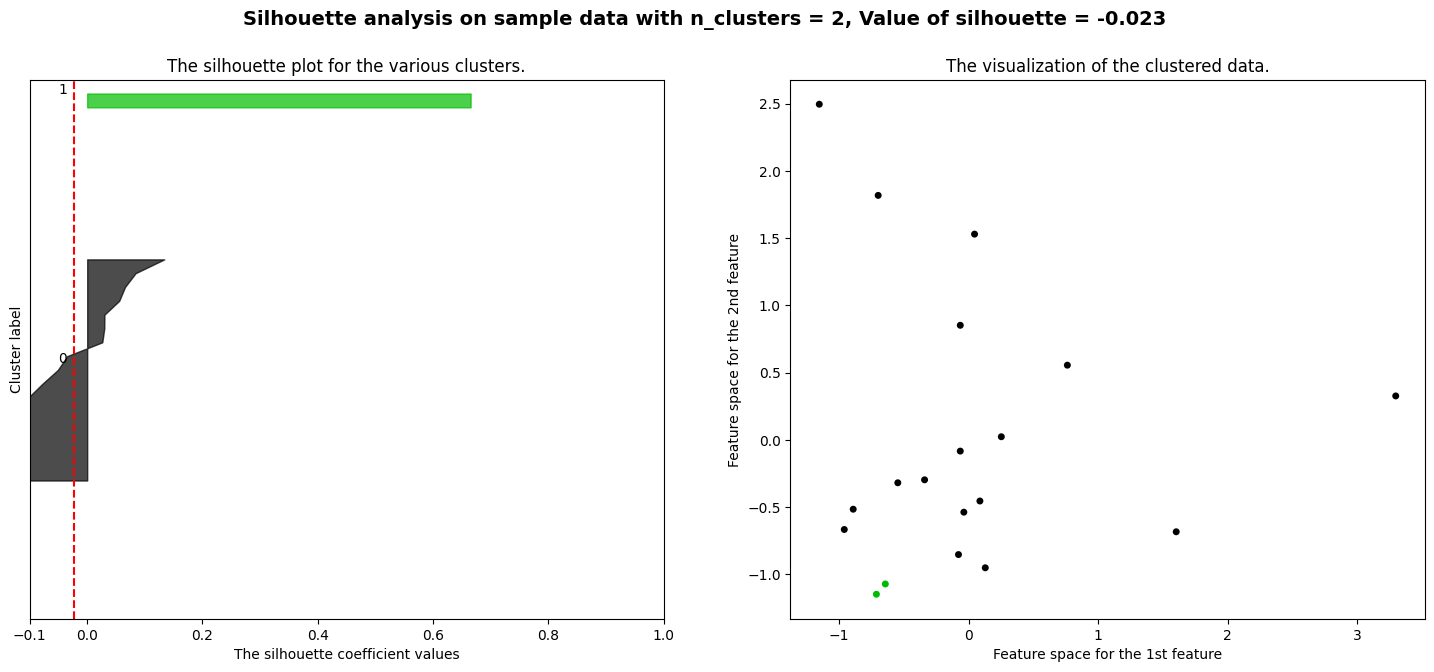

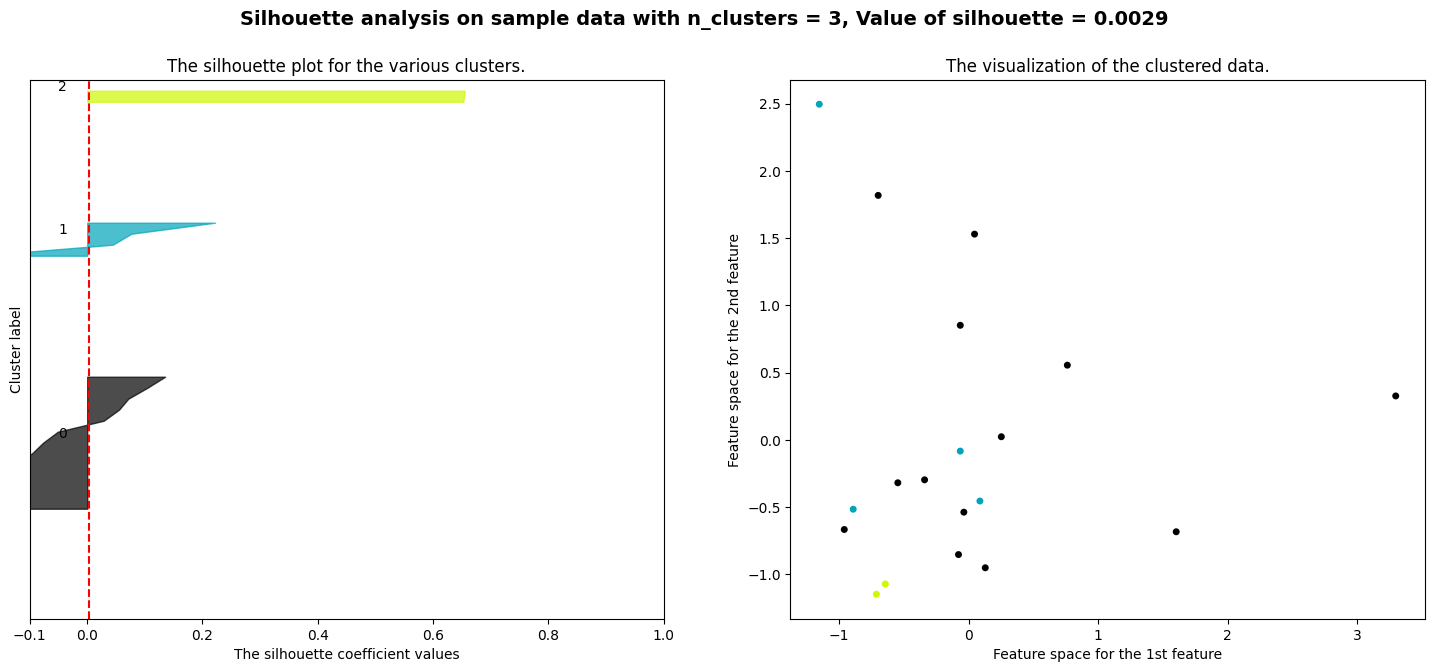

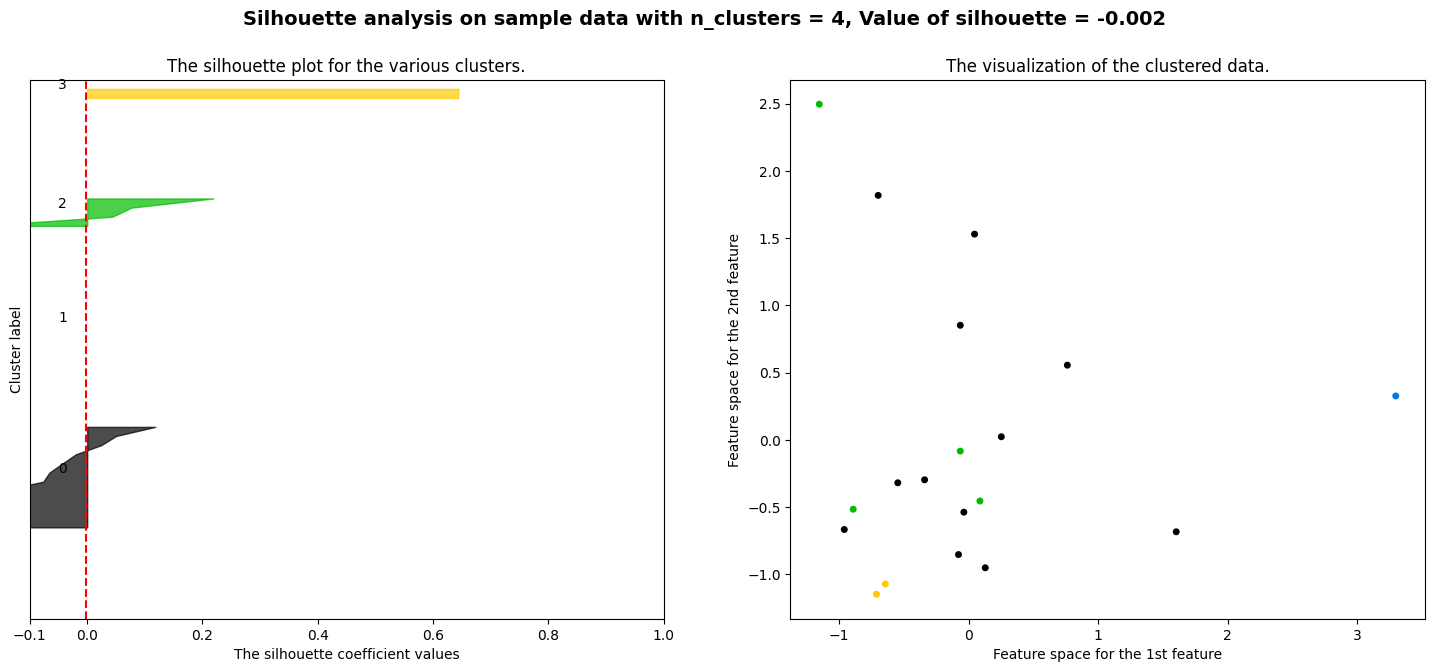

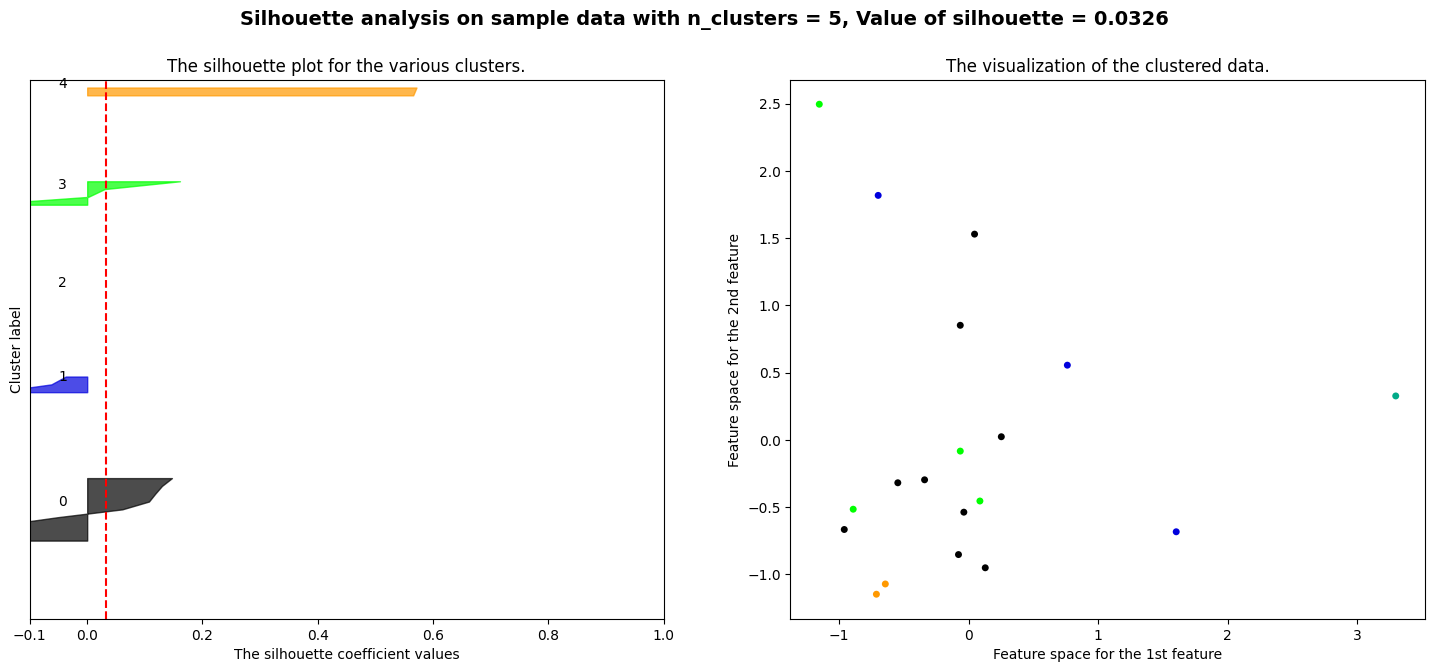

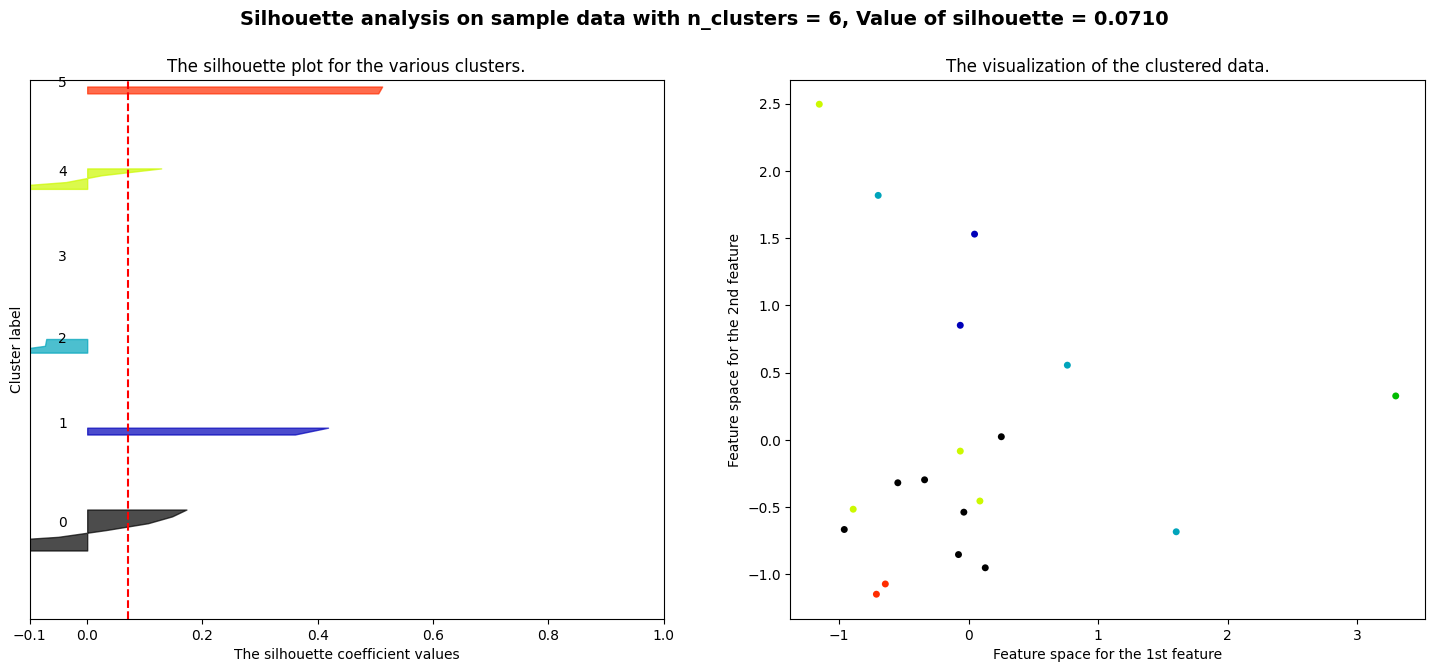

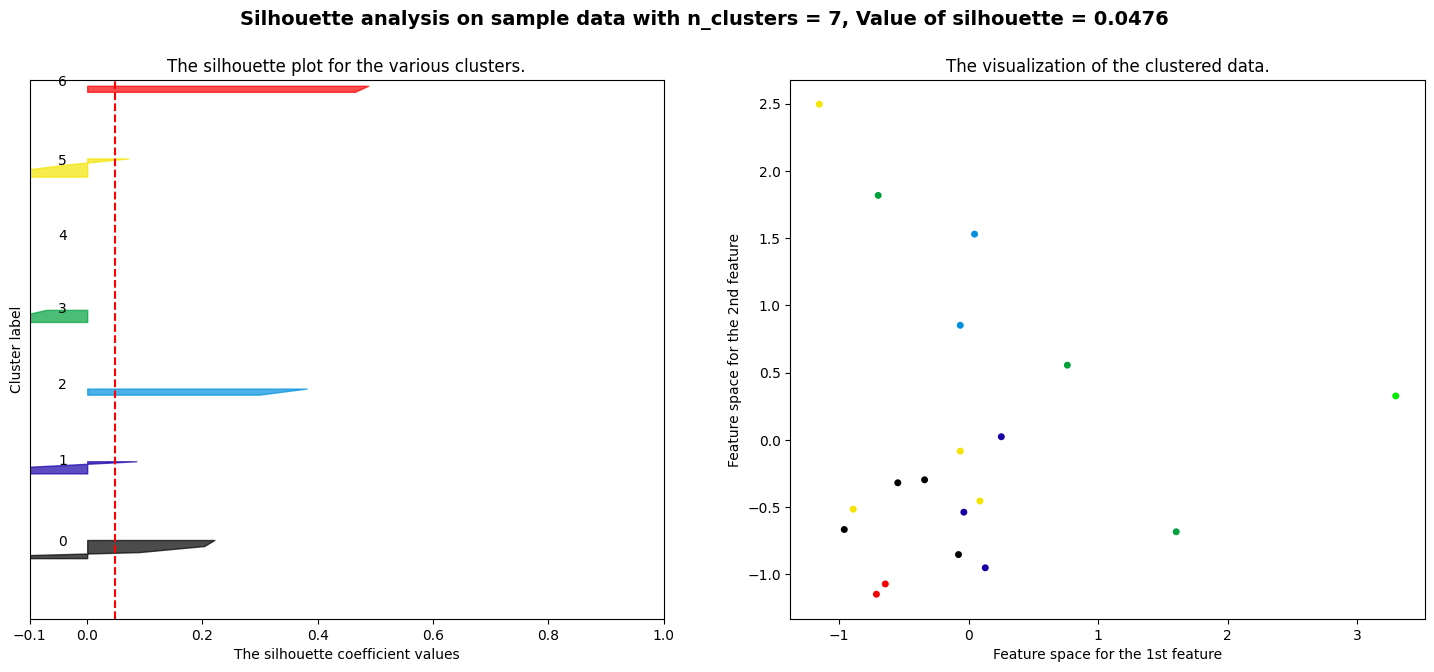

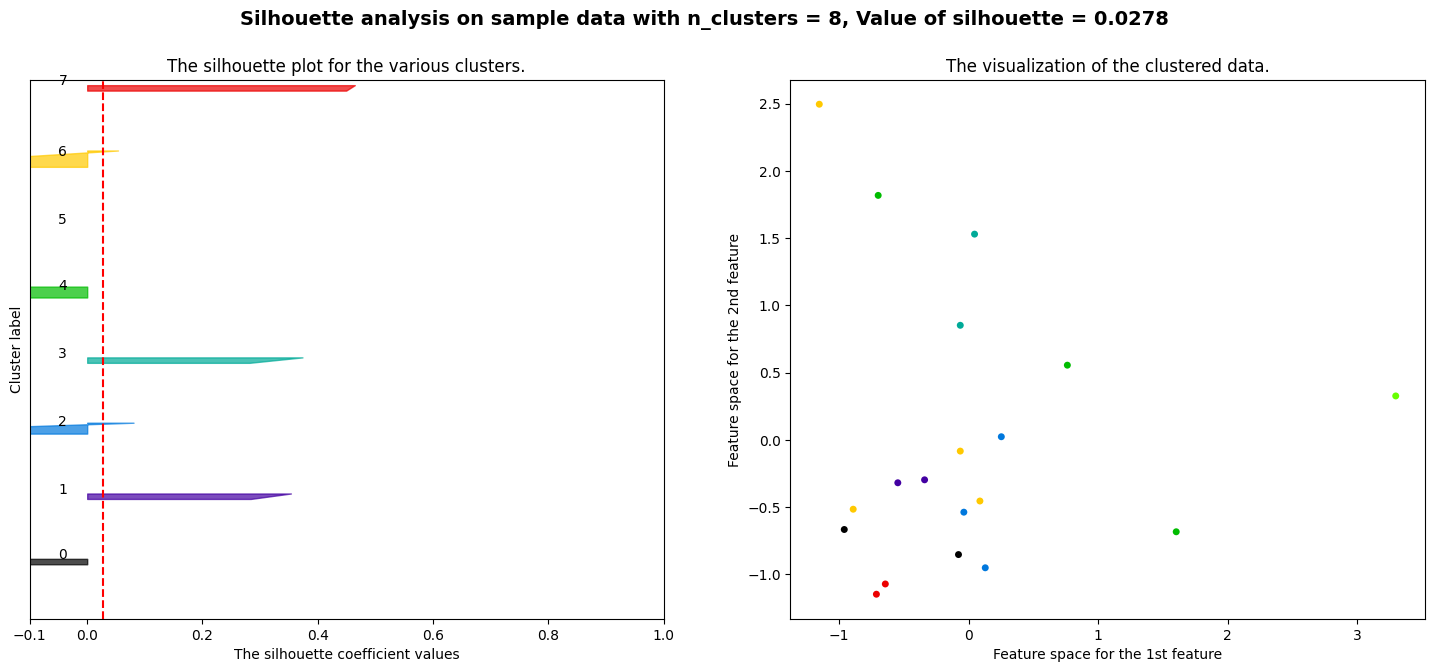

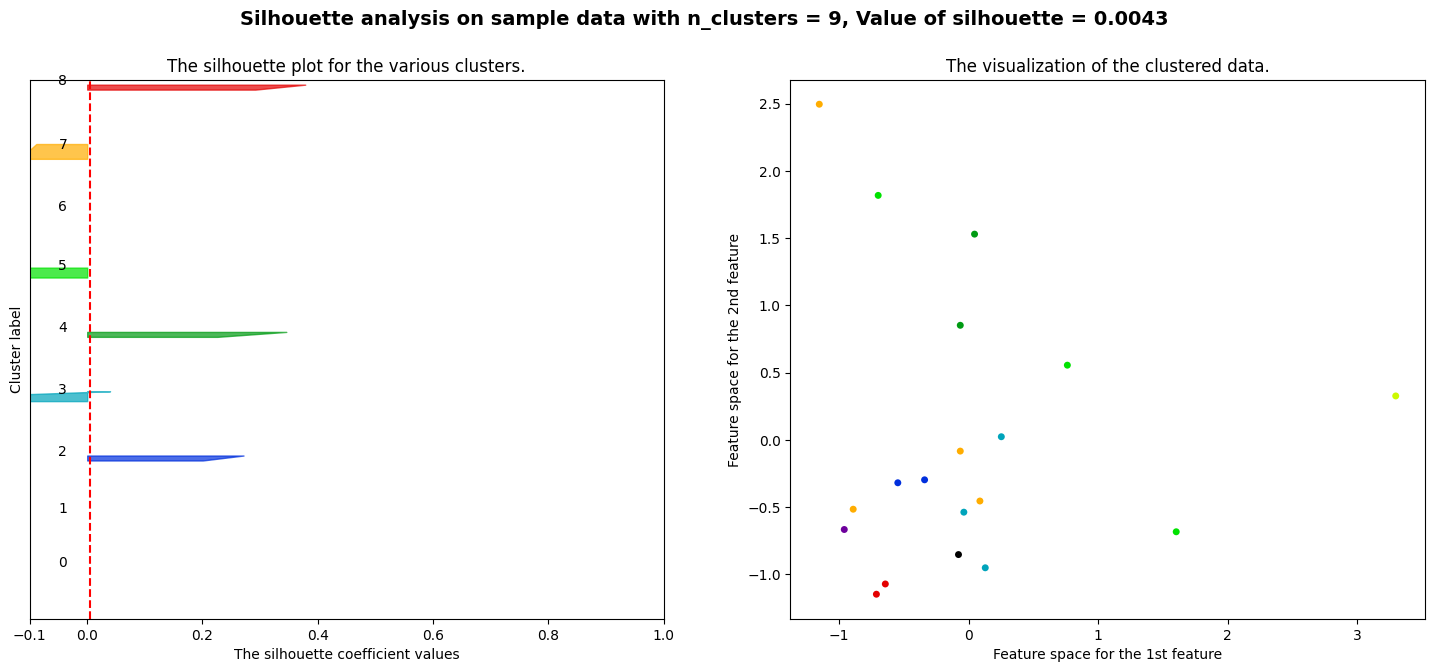

{'Number of\nClusters': dict_keys([2, 3, 4, 5, 6, 7, 8, 9]),
 'Silhouette\nAnalysis': ['-0.023',
  '0.002',
  '-0.002',
  '0.032',
  '0.071**',
  '0.047',
  '0.027',
  '0.004'],
 'Calinski\nHarabasz': ['1.420',
  '2.070',
  '2.027',
  '2.734*',
  '2.781**',
  '2.400',
  '2.095',
  '1.811'],
 'Davies\nBoulding': ['1.308',
  '1.716',
  '1.439',
  '1.326',
  '1.266*',
  '1.392',
  '1.385',
  '1.160**']}

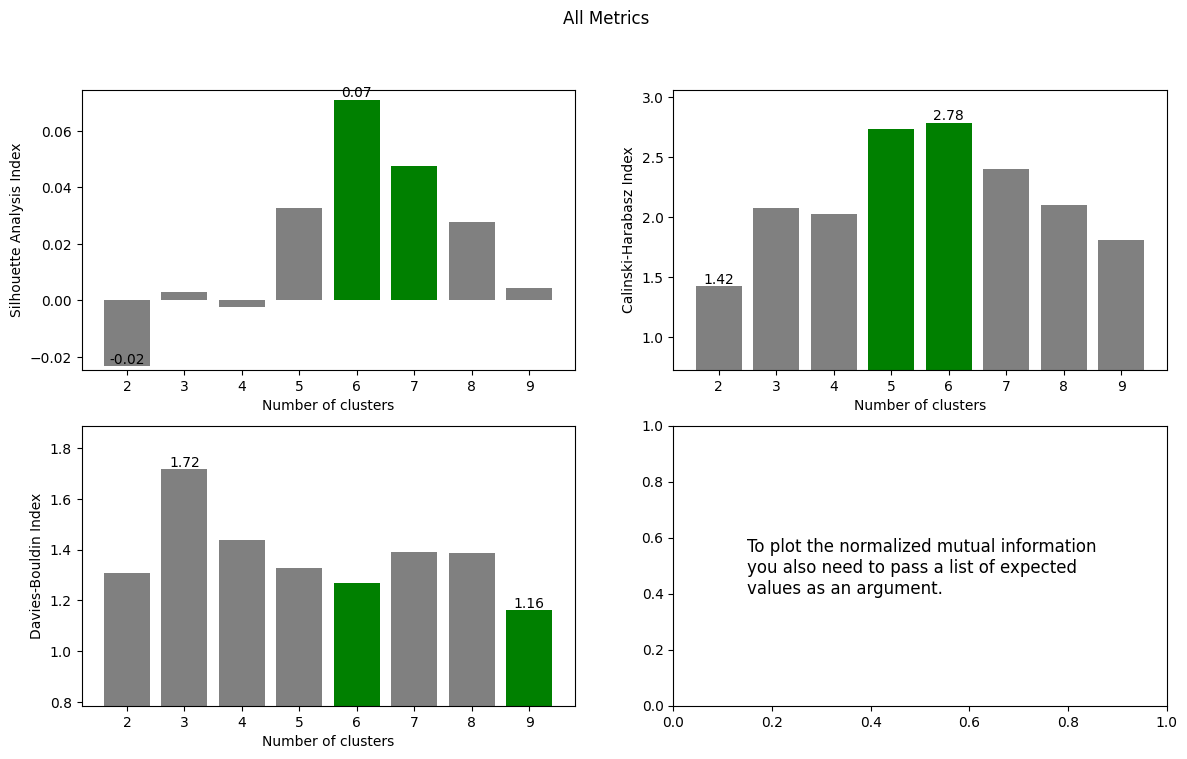

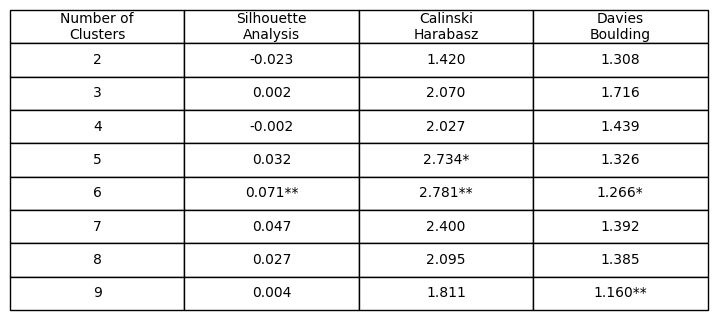

In [10]:
clusters_list_abril = []
for k in range(2, 10):
  clusters = som.n1_1.predict()
  clusters = som.adjust_clusters(clusters, groups = k)
  clusters_list_abril.append(clusters)
clusters_list_abril = np.array(clusters_list_abril)

mtr.print_metrics(clusters_list_abril, df_abril_values)

## Métricas de Outubro

In [11]:
SOM_outubro = som.create_SOM(10, learning = 0.05)
som.n1_1.design_weights(df_outubro_values)
som.n0_0.auto_organizing(epochs = 25, print_ = True)

Deleting old SOM template
Use object n1_1, it is your starting point for SOM...
To prepare the SOM for your data: n1_1.design_weights(YOUR_DATA) 
To start the SOM: n1_1.auto_organizing(epochs = 100)
 This function return the list of neurons
Adjust column 0
Adjust column 1
Adjust column 2
Adjust column 3
Adjust column 4
Adjust column 5
Adjust column 6
Adjust column 7
Adjust column 8
Adjust column 9
Adjust column 10
Adjust column 11
Adjust column 12
Adjust column 13
Adjust column 14
Adjust column 15
Adjust column 16
Adjust column 17
Adjust column 18
Adjust column 19
Adjust column 20
Adjust column 21
Adjust column 22
Adjust column 23
Adjust column 24
Adjust column 25
Adjust column 26
Adjust column 27
Adjust column 28
Adjust column 29
Adjust column 30
Adjust column 31
Adjust column 32
Adjust column 33
Adjust column 34
Adjust column 35
Adjust column 36
Adjust column 37
Adjust column 38
Adjust column 39
Adjust column 40
Adjust column 41
Adjust column 42
Adjust column 43
Adjust column 44
Adju

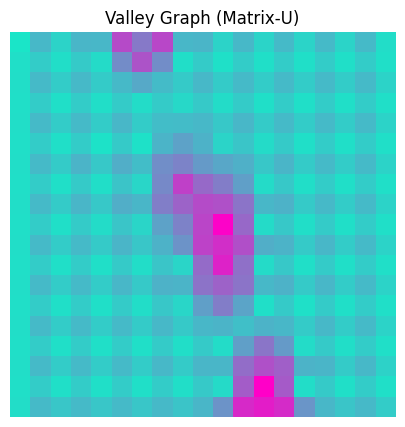

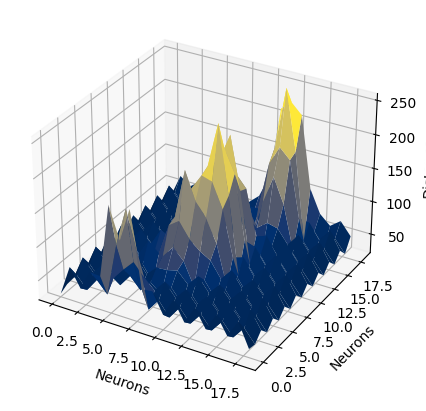

In [12]:
resp = som.n1_1.valley()

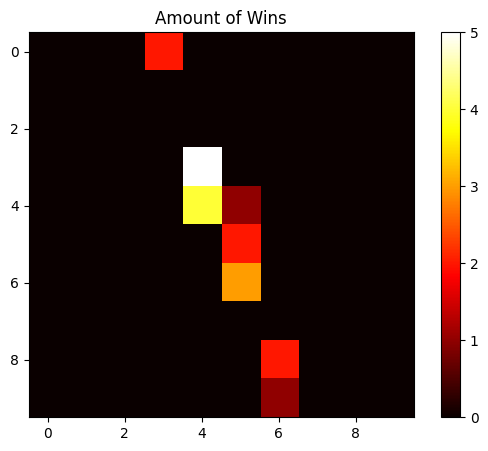

In [13]:
som.n1_1.amount_of_wins()

Max distance to join neurons: 0.2576582150648364
Neuron 0: group 21
Neuron 1: group 23
Neuron 2: group 36
Neuron 3: group 48
Neuron 4: group 4
Neuron 5: group 7
Neuron 6: group 18
Neuron 7: group 12
Neuron 8: group 3
Neuron 9: group 1
Neuron 10: group 21
Neuron 11: group 22
Neuron 12: group 34
Neuron 13: group 41
Neuron 14: group 5
Neuron 15: group 7
Neuron 16: group 18
Neuron 17: group 12
Neuron 18: group 3
Neuron 19: group 1
Neuron 20: group 21
Neuron 21: group 22
Neuron 22: group 33
Neuron 23: group 40
Neuron 24: group 6
Neuron 25: group 8
Neuron 26: group 18
Neuron 27: group 12
Neuron 28: group 3
Neuron 29: group 1
Neuron 30: group 21
Neuron 31: group 22
Neuron 32: group 33
Neuron 33: group 40
Neuron 34: group 43
Neuron 35: group 9
Neuron 36: group 19
Neuron 37: group 12
Neuron 38: group 3
Neuron 39: group 1
Neuron 40: group 21
Neuron 41: group 22
Neuron 42: group 35
Neuron 43: group 42
Neuron 44: group 44
Neuron 45: group 45
Neuron 46: group 20
Neuron 47: group 13
Neuron 48: group

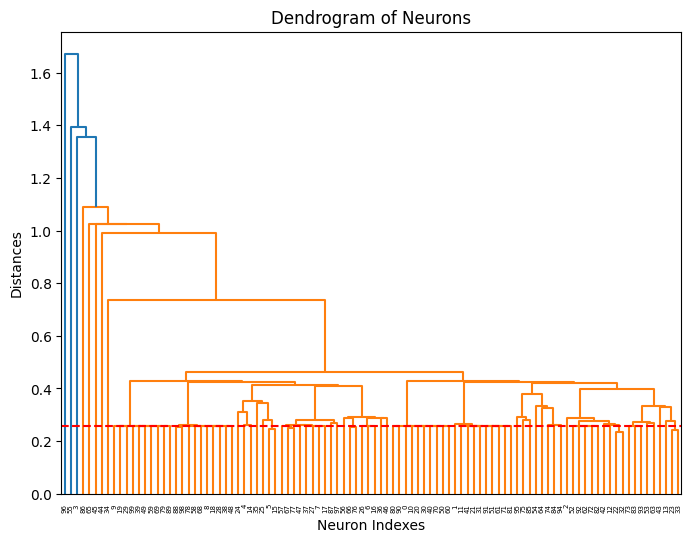

In [14]:
reps = som.n1_1.dendrogram()

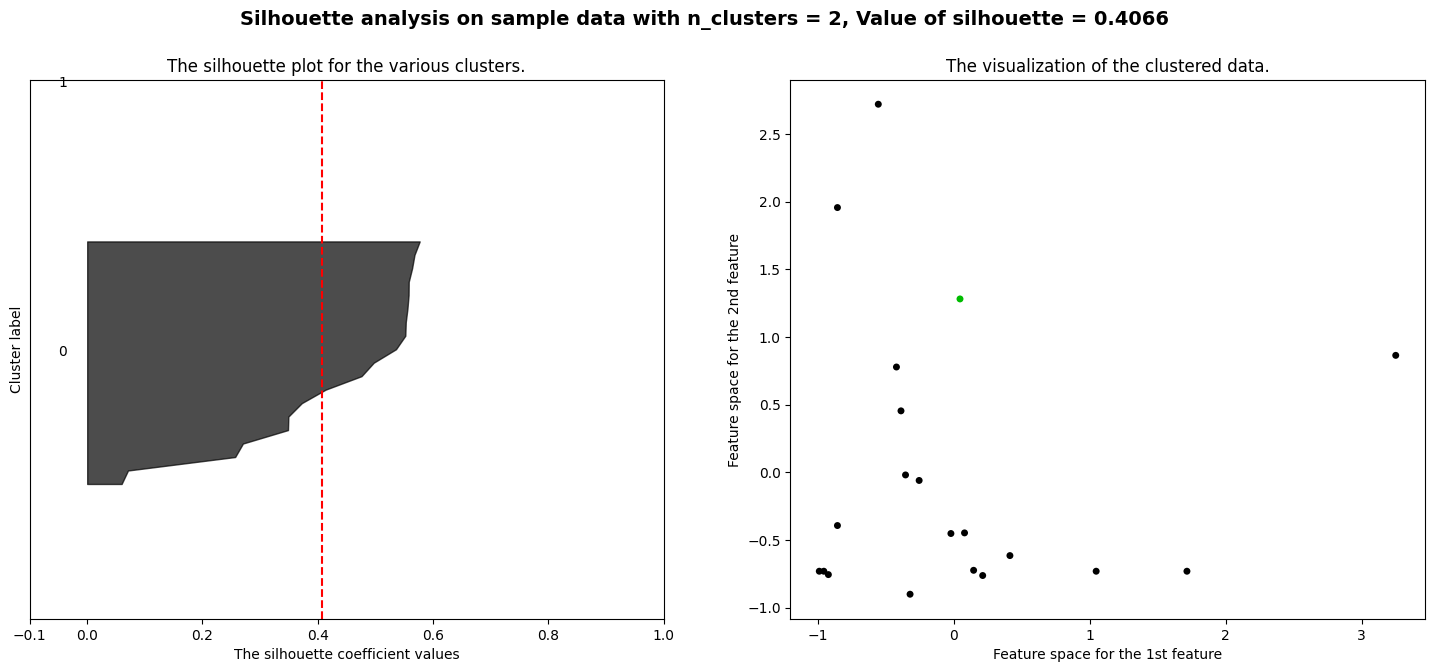

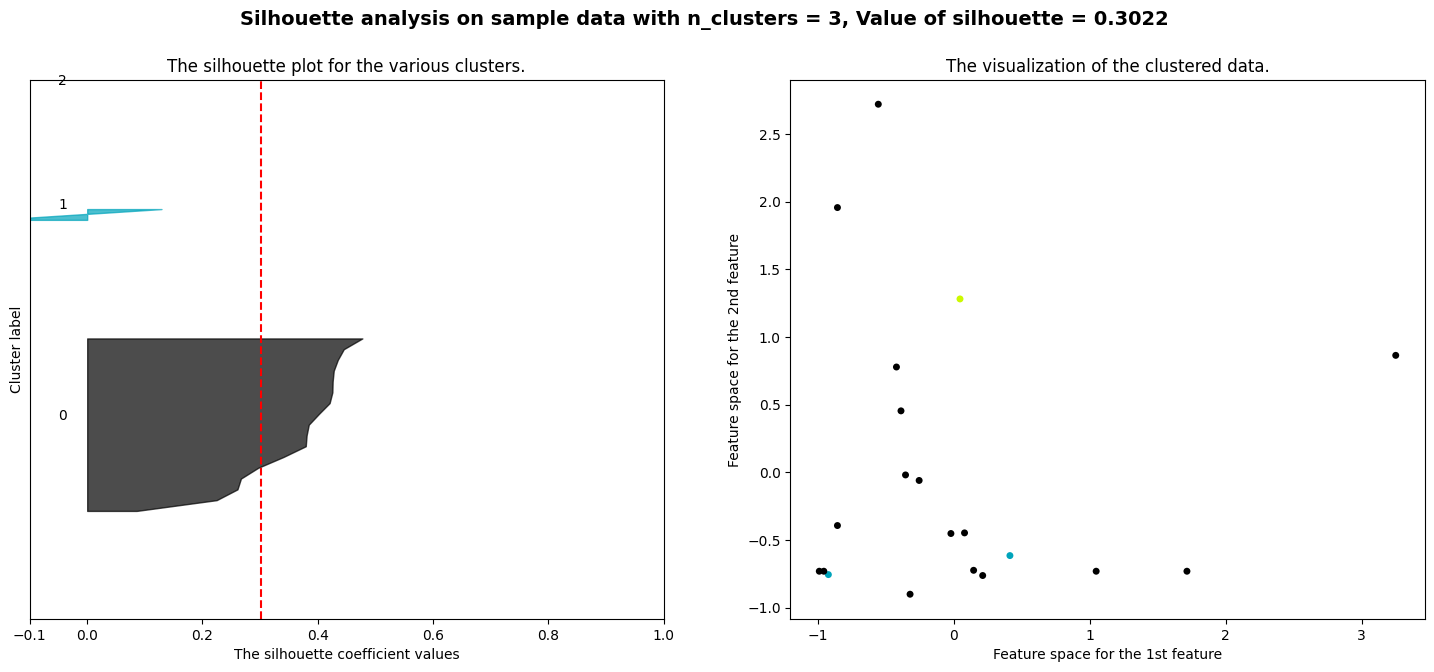

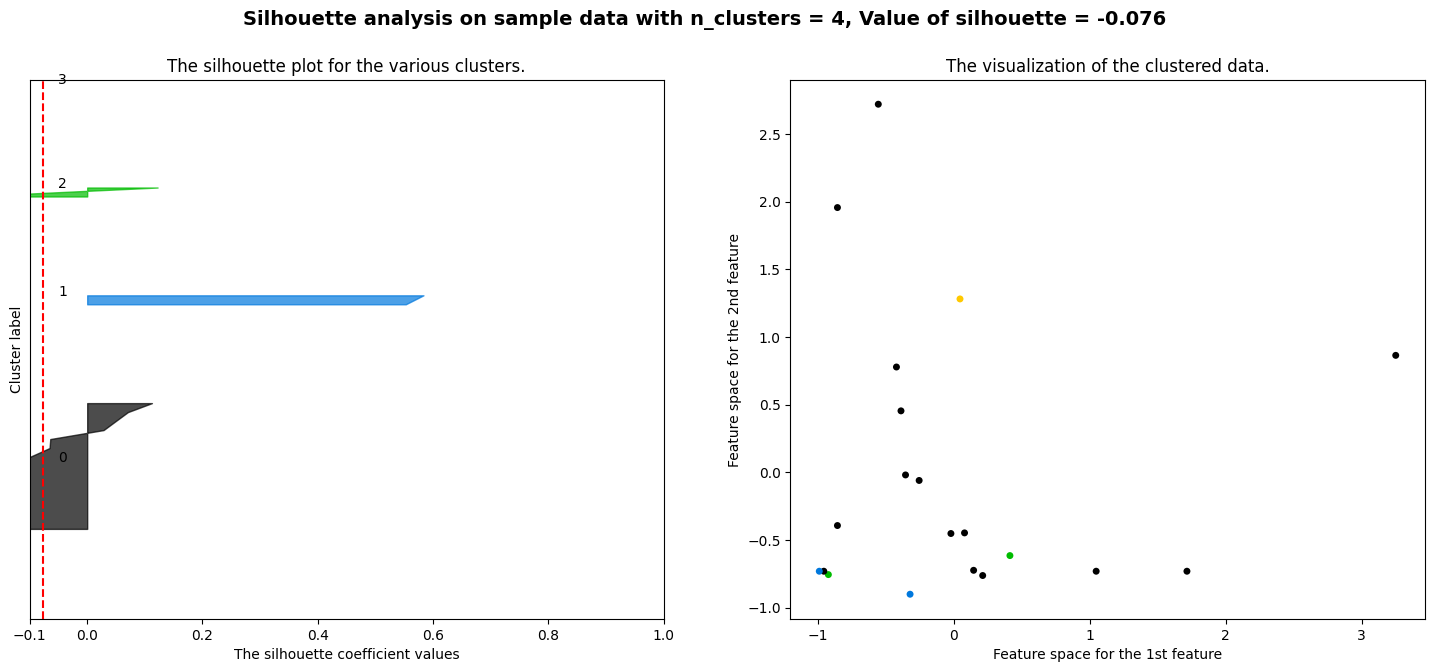

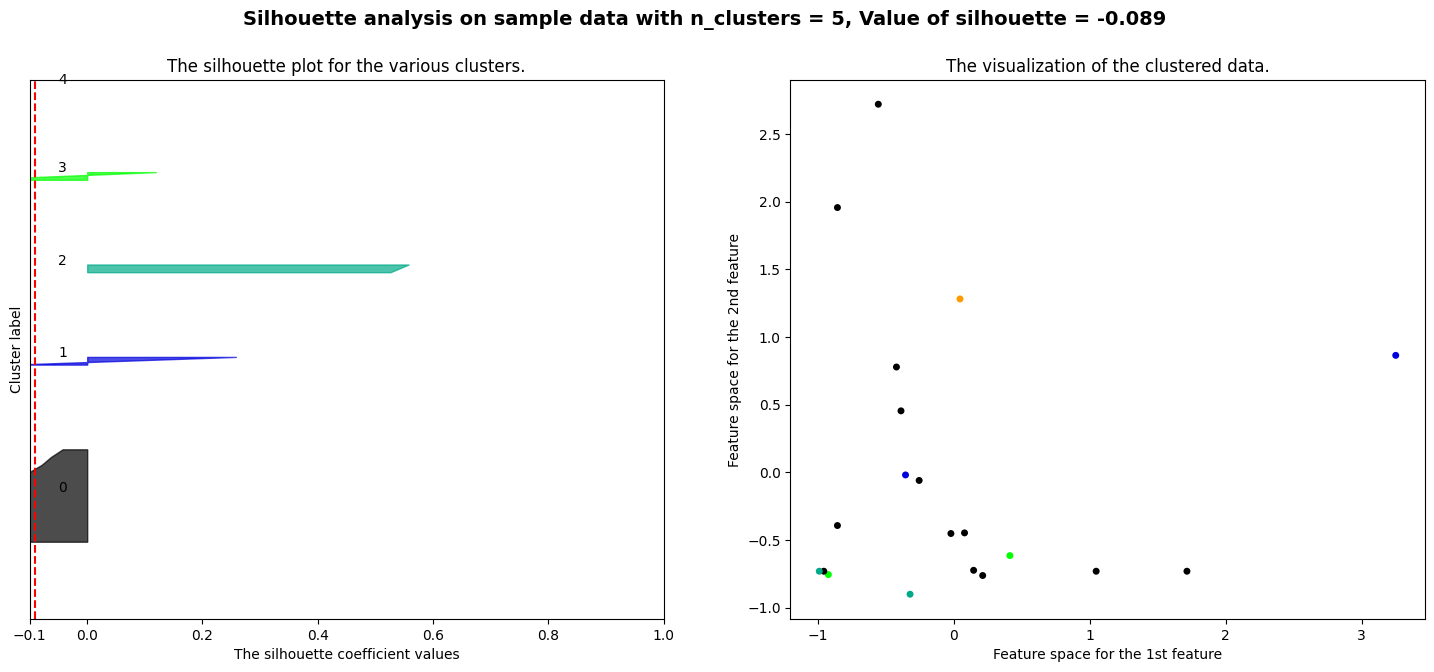

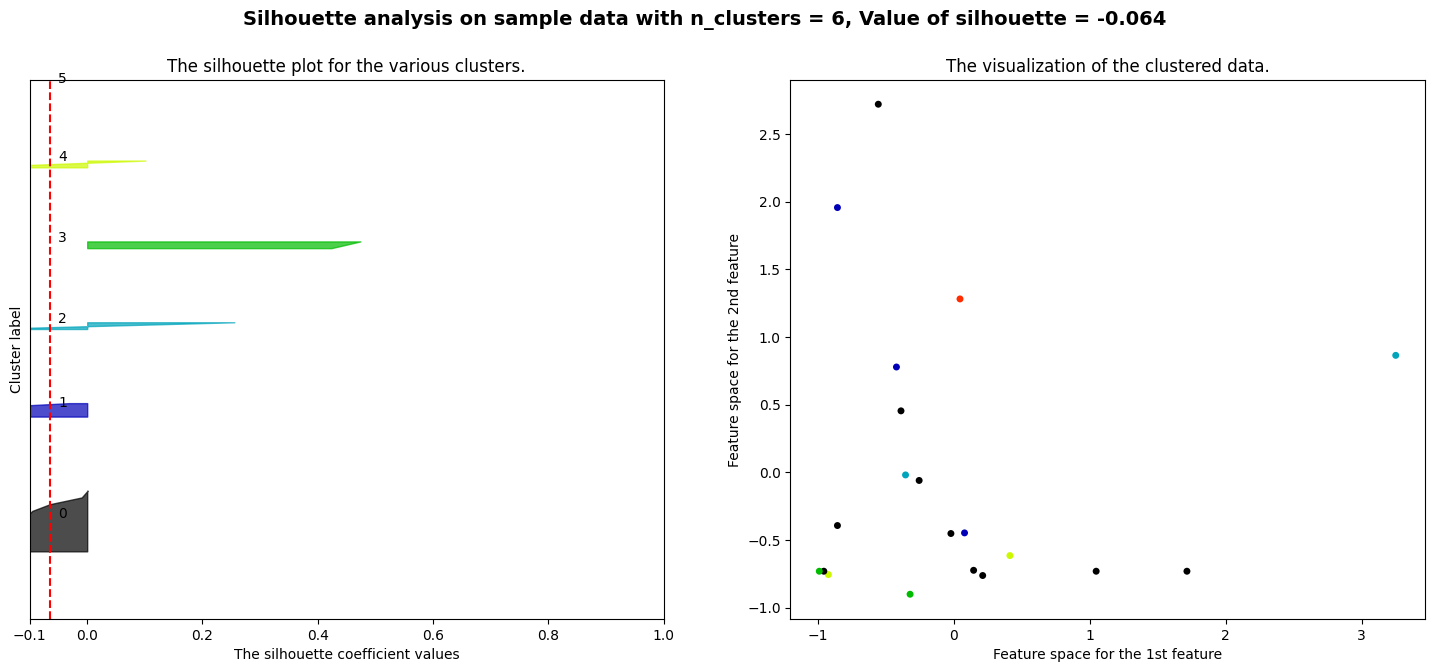

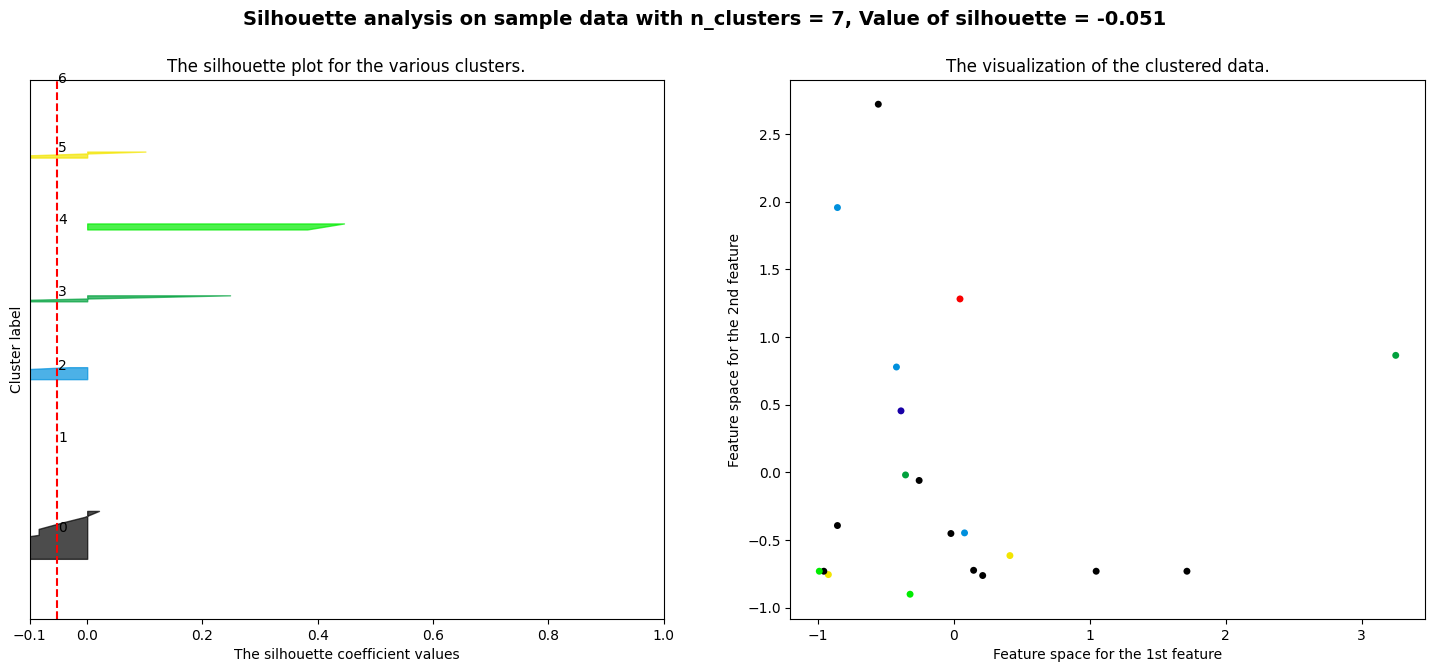

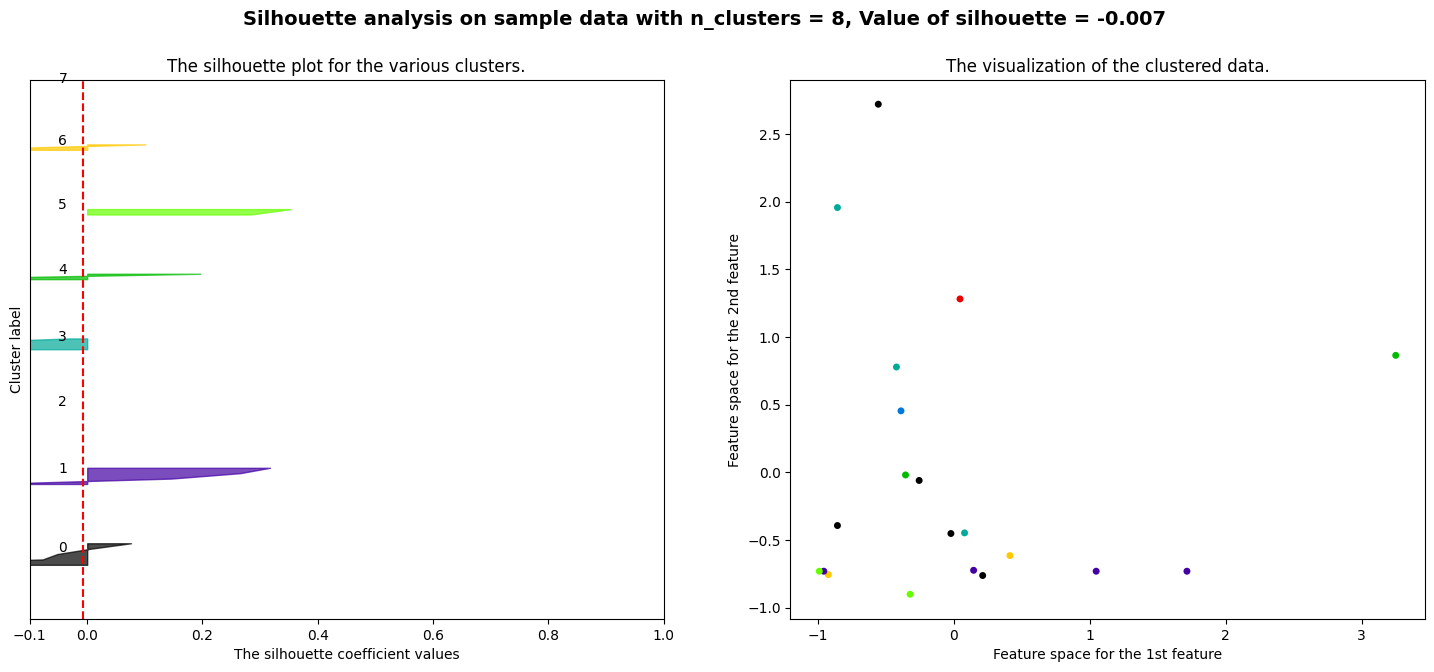

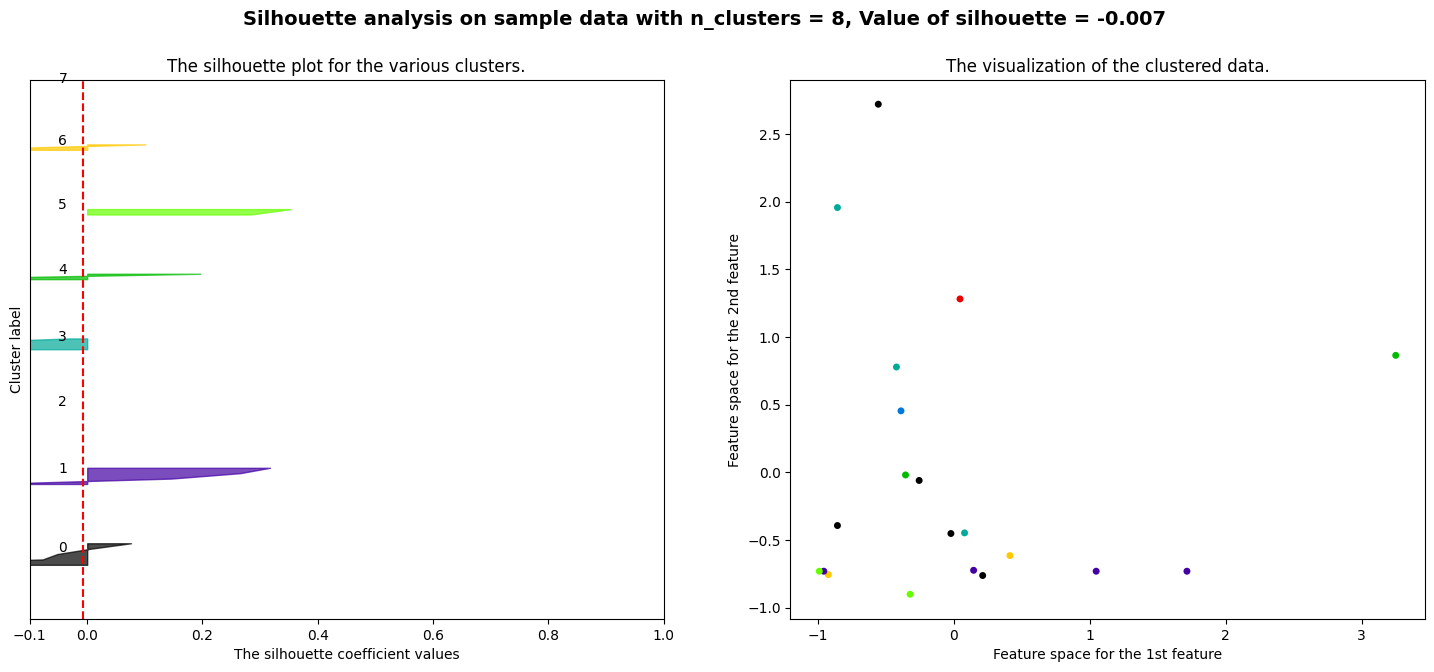

{'Number of\nClusters': dict_keys([2, 3, 4, 5, 6, 7, 8]),
 'Silhouette\nAnalysis': ['0.406**',
  '0.302',
  '-0.076',
  '-0.089',
  '-0.064',
  '-0.051',
  '-0.007'],
 'Calinski\nHarabasz': ['4.369*',
  '4.540**',
  '3.346',
  '3.067',
  '3.468',
  '3.316',
  '3.242'],
 'Davies\nBoulding': ['0.419**',
  '0.983',
  '1.205',
  '1.325',
  '1.440',
  '1.320',
  '1.250']}

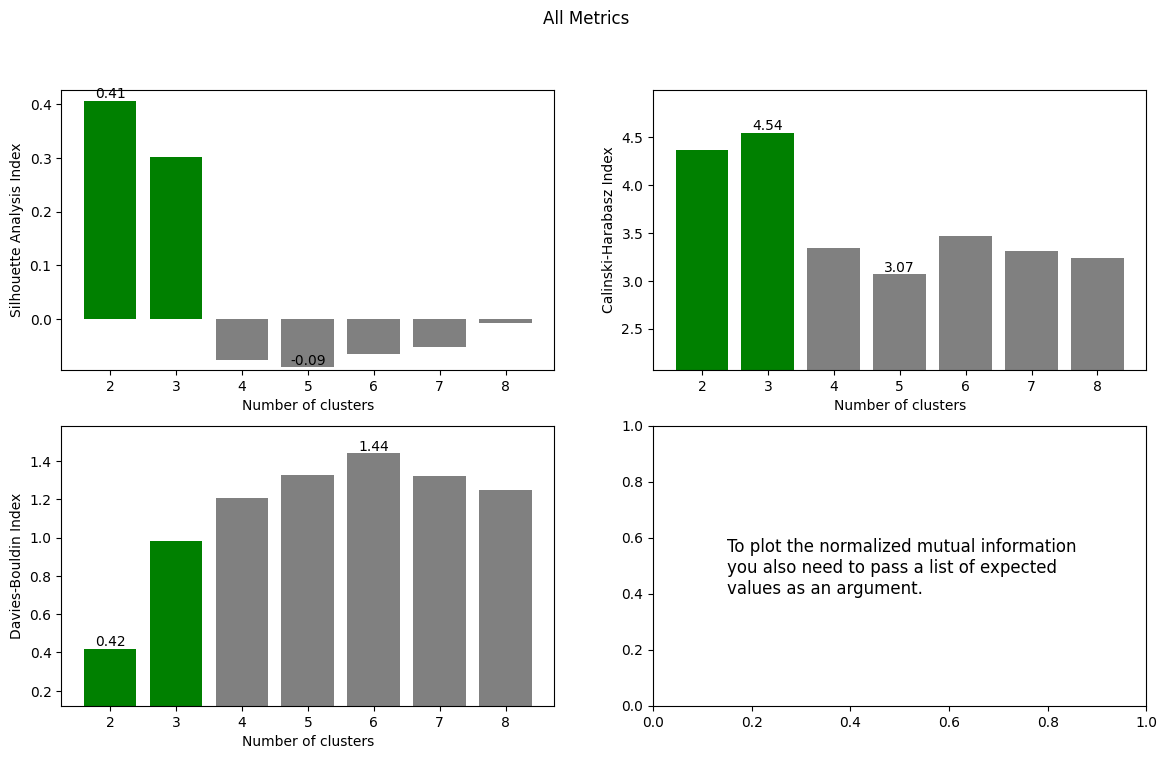

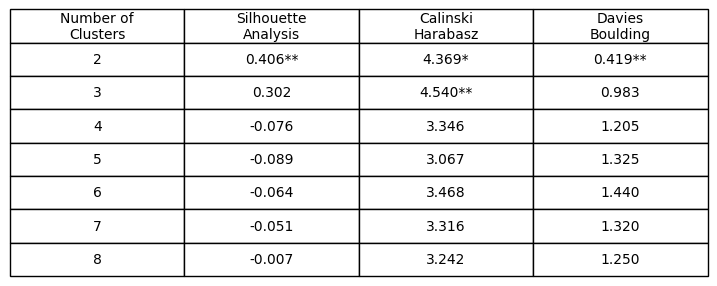

In [15]:
clusters_list_outubro = []
for k in range(2, 10):
  clusters = som.n1_1.predict()
  clusters = som.adjust_clusters(clusters, groups = k)
  clusters_list_outubro.append(clusters)
clusters_list_outubro = np.array(clusters_list_outubro)

mtr.print_metrics(clusters_list_outubro, df_outubro_values)

In [16]:
np.save('/content/drive/Shareddrives/datasci4water/IG/data/interim/clusters/som_ian_clusters_list_abril_com_coord.npy', clusters_list_abril)
np.save('/content/drive/Shareddrives/datasci4water/IG/data/interim/clusters/som_ian_clusters_list_outubro_com_coord.npy', clusters_list_outubro)

In [17]:
clusters_list_abril = np.load('/content/drive/Shareddrives/datasci4water/IG/data/interim/clusters/som_ian_clusters_list_abril_com_coord.npy')
clusters_list_outubro = np.load('/content/drive/Shareddrives/datasci4water/IG/data/interim/clusters/som_ian_clusters_list_outubro_com_coord.npy')

In [18]:
for k in range(2,10):
  # Criar um mapa usando folium
  mapa = folium.Map(location=coordenadas_abril[0], zoom_start=17)

  # Plotar os pontos no mapa com cores correspondentes aos rótulos
  cores = ['red', 'blue', 'green', 'orange', 'yellow', 'purple', 'black', 'pink', 'white']  # Cores para cada rótulo
  for i in range(df_abril.shape[0]):
      cor = cores[clusters_list_abril[k-2, i]]
      folium.CircleMarker(location=coordenadas_abril[i], color=cor, fill=True, fill_color=cor, radius=8, tooltip=(df_abril.iloc[i, 0], df_abril.iloc[i, 1])).add_to(mapa)

  # Exibir o mapa
  mapa.save(f"/content/drive/Shareddrives/datasci4water/IG/data/interim/maps/som_ian_abril_com_coord_k_{k}.html")


In [19]:
for k in range(2,9):
  # Criar um mapa usando folium
  mapa = folium.Map(location=coordenadas_outubro[0], zoom_start=17)

  # Plotar os pontos no mapa com cores correspondentes aos rótulos
  cores = ['red', 'blue', 'green', 'orange', 'yellow', 'purple', 'black', 'pink', 'white']  # Cores para cada rótulo
  for i in range(df_outubro.shape[0]):
      cor = cores[clusters_list_outubro[k-2, i]]
      folium.CircleMarker(location=coordenadas_outubro[i], color=cor, fill=True, fill_color=cor, radius=8, tooltip=(df_outubro.iloc[i, 0], df_outubro.iloc[i, 1])).add_to(mapa)

  # Exibir o mapa
  mapa.save(f"/content/drive/Shareddrives/datasci4water/IG/data/interim/maps/som_ian_outubro_com_coord_k_{k}.html")